# 1. Environment Setup

In [2]:
# Install necessary libraries (uncomment if running for the first time)
!pip install pandas numpy scikit-learn boto3 sagemaker mlflow xgboost
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

import os
import io
import pickle
import warnings
from datetime import datetime

import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import csr_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error)

import boto3
import sagemaker
from sagemaker import get_execution_role
import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 151.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 156.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 166.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 142.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.5/637.5 kB 33.6 MB/s eta 0:00:00
Using cached GitPython-3.1.44-py3-none-any.whl (207 kB)
Using cached gitdb-4.0.12-py3-none-any.whl (62 kB)
Using cached smmap-5.0.2-py3-none-any.whl (24 kB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.0
    Uninstalling pyarrow-19.0.0:
      Successfully uninstalled pyarrow-19.0.0
Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successf

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/29/25 23:46:56] INFO     Found credentials from IAM Role:                                   ]8;id=646189;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=3559;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## AWS Setup

In [3]:
# AWS Session Initialization
session = sagemaker.Session()
role = get_execution_role()

# Initialize S3 client
s3 = boto3.client('s3')

[01/29/25 23:47:01] INFO     Found credentials from IAM Role:                                   ]8;id=366526;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=914178;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=213076;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=161889;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[01/29/25 23:47:02] INFO     Found credentials from IAM Role:                                   ]8;id=443768;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=234945;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [4]:
BUCKET_NAME = 'sagemaker-bestcars-partex-data-storage'
RAW_DATA_PREFIX = 'data/raw'
PROCESSED_DATA_PREFIX = 'data/processed'
MODEL_PREFIX = 'models'

RAW_DATA_KEY = f'{RAW_DATA_PREFIX}/project_1_partex_valuation_data.xlsx'
PROCESSED_DATA_KEY = f'{PROCESSED_DATA_PREFIX}/' 
MODEL_KEY = f'{MODEL_PREFIX}/'

print(f"S3 Bucket: s3://{BUCKET_NAME}/{RAW_DATA_KEY}")
print(f"Raw Data File Key: s3://{BUCKET_NAME}/{RAW_DATA_KEY}")
print(f"Processed Data File Key: s3://{BUCKET_NAME}/{PROCESSED_DATA_KEY}")
print(f"Model Output File Key: s3://{BUCKET_NAME}/{MODEL_KEY}")


S3 Bucket: s3://sagemaker-bestcars-partex-data-storage/data/raw/project_1_partex_valuation_data.xlsx
Raw Data File Key: s3://sagemaker-bestcars-partex-data-storage/data/raw/project_1_partex_valuation_data.xlsx
Processed Data File Key: s3://sagemaker-bestcars-partex-data-storage/data/processed/
Model Output File Key: s3://sagemaker-bestcars-partex-data-storage/models/


## MLFlow Setup

In [5]:
mlflow_tracking_dir = os.path.expanduser("~/mlruns")
os.makedirs(mlflow_tracking_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file://{mlflow_tracking_dir}")

experiment_name = "Vehicle_Refurb_Cost_Prediction"
mlflow.set_experiment(experiment_name)
print(f"MLflow Experiment: {experiment_name}")

2025/01/29 23:47:02 INFO mlflow.tracking.fluent: Experiment with name 'Vehicle_Refurb_Cost_Prediction' does not exist. Creating a new experiment.


MLflow Experiment: Vehicle_Refurb_Cost_Prediction


In [6]:
# !mlflow ui --port 5000

## Helper Functions

In [7]:
def load_data_from_s3(bucket_name: str, file_key: str):
    """
    Load data from S3 bucket (can be raw or processed data).

    Parameters:
    - bucket_name: str. The name of the S3 bucket.
    - file_key: str. The key (path) to the file in S3 (e.g., 'data/raw/file.csv' or 'data/processed/file.csv')

    Returns:
    - A Pandas DataFrame containing the data if the file is loaded successfully; None otherwise.
    """
    try:
        # Download the file from S3
        s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
        
        # Check if the file has content
        file_body = s3_object['Body'].read()
        if not file_body:
            raise ValueError("The file is empty or not available.")
        
        # Extract the file extension to determine how to load it
        file_extension = file_key.split('.')[-1].lower()  
        
        # Read the file into a Pandas DataFrame based on its extension
        if file_extension == 'csv':
            df = pd.read_csv(io.BytesIO(file_body))
        elif file_extension in ['xls', 'xlsx']:
            df = pd.read_excel(io.BytesIO(file_body))
        elif file_extension == 'json':
            df = pd.read_json(io.BytesIO(file_body), orient='records', lines=True)
        elif file_extension == 'parquet':
            df = pd.read_parquet(io.BytesIO(file_body))
        else:
            raise ValueError(f"Unsupported file format: {file_extension}. Supported formats: CSV, Excel, JSON, Parquet.")
        
        print(f"Data loaded successfully from S3: {file_key}")
        return df
    
    except Exception as e:
        print(f"Error loading data from S3: {e}")
        return None


In [8]:
def upload_data_to_s3(bucket_name: str, file_key: str, data: pd.DataFrame) -> None:
    """
    Upload a Pandas DataFrame to an S3 bucket based on the file extension in file_key.

    Parameters:
    - bucket_name: str. The name of the S3 bucket.
    - file_key: str. The S3 path (including file name) to store the data.
    - data: pd.DataFrame. The data to be uploaded.

    Returns:
    - None
    """
    try:
        file_extension = file_key.split('.')[-1].lower()

        if file_extension == 'csv':
            with io.StringIO() as csv_buffer:
                data.to_csv(csv_buffer, index=False)
                s3.put_object(Bucket=bucket_name, Key=file_key, Body=csv_buffer.getvalue())

        elif file_extension == 'parquet':
            with io.BytesIO() as parquet_buffer:
                data.to_parquet(parquet_buffer, index=False)
                s3.put_object(Bucket=bucket_name, Key=file_key, Body=parquet_buffer.getvalue())

        elif file_extension == 'json':
            with io.StringIO() as json_buffer:
                data.to_json(json_buffer, orient='records', lines=True)
                s3.put_object(Bucket=bucket_name, Key=file_key, Body=json_buffer.getvalue())

        else:
            raise ValueError(f"Unsupported file format: {file_extension}. Supported formats: csv, parquet, json.")

        print(f"Data successfully uploaded to S3 at: {file_key}")

    except Exception as e:
        print(f"Error uploading data to S3: {e}")
        raise

In [9]:
def save_model_to_s3(model, model_name, bucket_name, model_prefix):
    """
    Save the trained model to S3 as a pickle file.
    
    Parameters:
        model: The trained model object.
        model_name: The name of the model.
        bucket_name: The S3 bucket name.
        model_prefix: The folder prefix for saving the model in S3.
    
    Returns:
        s3_model_path: The S3 path of the saved model.
    """
    # Create a time-based filename for versioning
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f'{model_name}_{timestamp}.pkl'
    
    # Save model to a local file
    local_model_path = f'/tmp/{model_filename}'
    with open(local_model_path, 'wb') as f:
        pickle.dump(model, f)

    # Create S3 path
    s3_model_path = f'{model_prefix}/{model_filename}'
    
    # Upload model to S3
    s3_client = boto3.client('s3')
    s3_client.upload_file(local_model_path, bucket_name, s3_model_path)

    print(f"Model saved to: s3://{bucket_name}/{s3_model_path}")
    return s3_model_path

In [10]:
def load_model_from_s3(BUCKET_NAME, model_path):
    s3_client = boto3.client('s3')
    
    # Local path to store the downloaded model temporarily
    local_model_path = f"/tmp/{model_path.split('/')[-1]}"
    
    # Download the model file from S3
    s3_client.download_file(BUCKET_NAME, model_path, local_model_path)
    
    # Load the model from the local file
    with open(local_model_path, "rb") as f:
        model = pickle.load(f)
    
    return model

In [11]:
def get_prediction_intervals(model, X_test, n_iter=100, percentile=5):
    """
    Compute prediction intervals using bootstrap resampling.

    Parameters:
        model: Trained machine learning model with a `predict` method.
        X_test: Test dataset (can be sparse or dense).
        n_iter: Number of bootstrap iterations.
        percentile: Percentile for interval calculation (default 5 for 90% interval).

    Returns:
        lower_bound: Lower bound of prediction intervals.
        upper_bound: Upper bound of prediction intervals.
    """
    if isinstance(X_test, csr_matrix):
        X_test = X_test.toarray()

    n_samples = X_test.shape[0]
    predictions = np.zeros((n_iter, n_samples))  

    
    for i in range(n_iter):
        
        sample_idx = np.random.randint(0, n_samples, size=n_samples) 
        X_sample = X_test[sample_idx]

        
        predictions[i] = model.predict(X_sample)

    
    lower_bound = np.percentile(predictions, percentile, axis=0)
    upper_bound = np.percentile(predictions, 100 - percentile, axis=0)

    return lower_bound, upper_bound


# 2. Data Loading

In [12]:
df = load_data_from_s3(BUCKET_NAME, RAW_DATA_KEY)

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=978461;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=38503;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

Data loaded successfully from S3: data/raw/project_1_partex_valuation_data.xlsx


In [13]:
df =df.copy()

In [14]:
df.head(20)

,VRM,VEHICLE_ID,CREATED_DATE,VIN_VEHICLE_ID_RANK_DESC,CAP_ID,MMAF,MAKE,ACTUAL_REFURB_COST,MAX_COMPLETE_DATE,ALL_REFURB_DAYS_DIFF,CAPID_DAYS_DIFF,MMAF_DAYS_DIFF,VEHICLE_TRIM,AVG_CAPID_REFURB_COST,AVG_MMAF_REFURB_COST,CAP_CLEAN,VEHICLE_AGE__MONTHS,VEHICLE_SOURCE,TRANSMISSION_TYPE,REGISTERED_KEEPERS,ODOMETER_MILES,MODEL,COLOUR,BODY_TYPE,FUEL_TYPE,REGISTRATION_DATE
0,YY73XJV,268b15b3-9798-43ca-806c-0336d6ba4283,2024-08-07 14:36:53.390,1,104233.0,JEEPAVENGERLess than 1 Year OldPETROL,JEEP,267.390,2024-09-01,25,51.800,60.666,ALTITUDE,245.175600,246.600000,20250.0,7.366667,OUTSOURCED,MANUAL,2.0,8400.0,AVENGER,WHITE,SUV,Petrol,2023-12-30
1,YY73NJV,d095215e-7858-4001-b92d-fac15330c992,2024-09-09 22:50:17.370,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,230.682,2024-09-16,7,42.866,51.125,NaN,269.458000,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,30.0,500C,GREY,Convertible,Petrol,2023-09-30
2,YY73NHT,5594ceb5-f928-4e06-83a2-aba620aa2dd1,2024-09-09 22:50:20.220,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,263.142,2024-11-21,73,42.866,51.125,NaN,269.458000,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,34.0,500C,RED,Convertible,Petrol,2023-09-30
3,YY73NHN,979562e7-ca33-4752-b41b-38115f73f252,2024-09-09 22:50:17.573,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,227.556,2024-09-20,11,42.866,51.125,NaN,269.458000,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,28.0,500C,BLUE,Convertible,Petrol,2023-09-30
4,YY73NFN,918c93fe-f02b-4b76-8b12-94f60344a682,2024-09-09 22:50:17.504,1,101141.0,FIAT500CLess than 1 Year OldPETROL,FIAT,222.930,2024-10-05,26,42.866,24.500,NaN,269.458000,237.775000,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,34.0,500C,RED,Convertible,Petrol,2023-09-30
5,YY73NFD,8a7a870b-a6d6-4c73-9692-81713bba4c45,2024-09-09 22:50:17.491,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,231.411,2024-10-07,28,42.866,51.125,NaN,269.458000,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,31.0,500C,RED,Convertible,Petrol,2023-09-30
6,YY73NEO,6d35aef9-d77a-4d2d-a279-73a7b21df606,2024-09-09 22:50:20.247,1,101141.0,FIAT500CLess than 1 Year OldPETROL,FIAT,252.620,2024-10-02,23,42.866,24.500,NaN,269.458000,237.775000,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,37.0,500C,BLUE,Convertible,Petrol,2023-09-30
7,YY73NDU,b164608b-3b12-4371-992b-aee266606877,2024-09-09 22:50:20.285,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,293.774,2024-11-25,77,42.866,51.125,NaN,269.458000,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,33.0,500C,RED,Convertible,Petrol,2023-09-30
8,YY73GKV,a177386a-5963-4618-b5a2-f028eabde82a,2024-09-09 22:50:17.435,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,593.410,2024-12-04,86,42.866,51.125,NaN,269.458000,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,32.0,500C,BLUE,Convertible,Petrol,2023-09-30
9,YY73CXJ,b411ae5c-3b97-4924-89fb-11dc9a9e2831,2024-08-06 22:50:17.058,1,102934.0,RENAULTAUSTRALLess than 1 Year OldPETROLELECTR...,RENAULT,267.310,2024-08-28,22,22.000,22.000,TECHNO,267.310000,267.310000,25050.0,10.433333,OUTSOURCED,SEMI-AUTO,1.0,15233.0,AUSTRAL,BLACK,SUV,Hybrid,2023-09-28


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54884 entries, 0 to 54883
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   VRM                       54884 non-null  object        
 1   VEHICLE_ID                54884 non-null  object        
 2   CREATED_DATE              54884 non-null  datetime64[ns]
 3   VIN_VEHICLE_ID_RANK_DESC  54884 non-null  int64         
 4   CAP_ID                    54883 non-null  float64       
 5   MMAF                      54878 non-null  object        
 6   MAKE                      54884 non-null  object        
 7   ACTUAL_REFURB_COST        54884 non-null  float64       
 8   MAX_COMPLETE_DATE         54884 non-null  datetime64[ns]
 9   ALL_REFURB_DAYS_DIFF      54884 non-null  int64         
 10  CAPID_DAYS_DIFF           54884 non-null  float64       
 11  MMAF_DAYS_DIFF            54884 non-null  float64       
 12  VEHICLE_TRIM      

In [16]:
print(df.describe())

       VIN_VEHICLE_ID_RANK_DESC         CAP_ID  ACTUAL_REFURB_COST  ALL_REFURB_DAYS_DIFF  CAPID_DAYS_DIFF  MMAF_DAYS_DIFF  AVG_CAPID_REFURB_COST  AVG_MMAF_REFURB_COST     CAP_CLEAN  VEHICLE_AGE__MONTHS  REGISTERED_KEEPERS  ODOMETER_MILES
count              54884.000000   54883.000000         54884.00000          54884.000000     54884.000000    54884.000000           54884.000000          54884.000000  54853.000000         54884.000000        54709.000000    54883.000000
mean                   1.018512   85688.661553           623.02863             54.819692        60.585057       60.247247             597.627494            610.837663  13081.790877            53.885947            1.734194    34412.145582
std                    0.238092    8666.173644           413.30514             32.724046        18.015671       12.992437             207.505190            166.750440   5025.412160            19.656427            0.899138    17297.150000
min                    1.000000       0.000000  

# 3. Data Cleaning and Feature Engineering

In [17]:
def handle_missing_values(df, drop_threshold=0.1, fill_strategy='mean'):
    """
    Handles missing values in the DataFrame.
    - Drops rows where missing percentage is less than the specified threshold.
    - Fills missing values using group-specific means or modes based on MMAF.(can be changed)
    - Allows flexibility for different filling strategies.
    
    Parameters:
        df (DataFrame): The input data.
        drop_threshold (float): Threshold for dropping columns/rows based on missing percentage (0 to 1).
        fill_strategy (str): The strategy to fill missing values ('mean', 'mode', or 'median').
    
    Returns:
        df (DataFrame): DataFrame with missing values handled.
    """
    missing_columns = df.columns[df.isnull().any()]
    
    # Iterate through each column with missing values
    for col in missing_columns:
        missing_percentage = df[col].isnull().mean()
        
        # Drop rows if the missing percentage is below the threshold
        if missing_percentage < drop_threshold:
            df = df.dropna(subset=[col])
        else:
            if df[col].dtype == 'object':
                # For categorical columns, use mode or a more flexible strategy
                if fill_strategy == 'mode':
                    df[col] = df.groupby('MMAF')[col].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))
                elif fill_strategy == 'most_frequent':
                    # More flexible strategy (using the most frequent value in the group)
                    df[col] = df.groupby('MMAF')[col].apply(lambda x: x.fillna(x.value_counts().idxmax() if not x.value_counts().empty else 'unknown'))
                else:
                    # For unknown strategies, set as 'unknown'
                    df[col] = df.fillna('unknown')
            else:
                # For numeric columns, use mean, median, or a more complex strategy
                if fill_strategy == 'mean':
                    df[col] = df.groupby('MMAF')[col].apply(lambda x: x.fillna(x.mean()))
                elif fill_strategy == 'median':
                    df[col] = df.groupby('MMAF')[col].apply(lambda x: x.fillna(x.median()))
                else:
                    # Default to mean if strategy is not recognized
                    df[col] = df.groupby('MMAF')[col].apply(lambda x: x.fillna(x.mean()))
    
    return df


In [18]:
def handle_outliers(df, z_score_threshold=3, iqr_threshold=1.5, fill_outliers=False, fill_strategy='mean'):
    """
    Detects and handles outliers from numeric columns of the DataFrame.
    - Uses Z-Score for normal data.
    - Uses IQR for skewed data.
    - Option to fill outliers instead of removing them.
    
    Parameters:
        df (DataFrame): The input data.
        z_score_threshold (float): Threshold for Z-Score method.
        iqr_threshold (float): Threshold for IQR method.
        fill_outliers (bool): If True, outliers are filled with fill_strategy, else removed.
        fill_strategy (str): Strategy for filling outliers ('mean', 'median', or 'mode').
    
    Returns:
        df (DataFrame): DataFrame with outliers handled.
    """
    for column in df.select_dtypes(include=['number']).columns:
        column_data = df[column].dropna()

        # Normality check using Shapiro-Wilk Test
        _, p_value = stats.shapiro(column_data)
        
        if p_value > 0.05:  # If data is normally distributed, use Z-Score
            z_scores = np.abs(stats.zscore(column_data))
            outliers = column_data[z_scores > z_score_threshold]
            
            if fill_outliers:
                fill_value = column_data.mean() if fill_strategy == 'mean' else column_data.median() if fill_strategy == 'median' else column_data.mode()[0]
                df[column] = np.where(z_scores > z_score_threshold, fill_value, column_data)
            else:
                df = df[z_scores <= z_score_threshold]
        
        else:  # If data is skewed, use IQR
            Q1 = column_data.quantile(0.25)
            Q3 = column_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_threshold * IQR
            upper_bound = Q3 + iqr_threshold * IQR
            outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]
            
            if fill_outliers:
                fill_value = column_data.mean() if fill_strategy == 'mean' else column_data.median() if fill_strategy == 'median' else column_data.mode()[0]
                df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), fill_value, df[column])
            else:
                df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df


In [19]:
# TODO : add more features !!
def feature_engineering(df):
    """
    Creates new features for the DataFrame.
    """
    try:
        df['VEHICLE_AGE_DAYS'] = (df['CREATED_DATE'] - df['REGISTRATION_DATE']).dt.days
        print("Feature engineering completed.")
        return df
    except Exception as e:
        print(f"Error in feature engineering: {e}")
        return None

In [20]:
def convert_numeric_to_categorical(df, threshold=15):
    """
    Convert numeric columns to categorical if the number of unique values is below the specified threshold.
    
    Parameters:
    - df (DataFrame): The input dataframe containing numeric columns.
    - threshold (int): The maximum number of unique values for converting a numeric column to categorical.
    
    Returns:
    - df (DataFrame): The dataframe with numeric columns converted to categorical, where applicable.
    """
    for column in df.select_dtypes(include=['number']).columns:
        unique_values_count = df[column].nunique()
        if unique_values_count < threshold:
            df[column] = df[column].astype('category')
            print(f"Column '{column}' converted to categorical (less than {threshold} unique values).")
        else:
            print(f"Column '{column}' remains numeric (more than {threshold} unique values).")
    
    return df


In [21]:
def data_preprocessing(df, BUCKET_NAME, PROCESSED_DATA_PREFIX, target_column='ACTUAL_REFURB_COST', threshold=15):
    """
    Complete preprocessing pipeline:
    - Handles missing values.
    - Creates new features.
    - Prepares train/test datasets.
    - Scales numeric features and encodes categorical features.
    - Handles outliers.
    - Converts numeric columns to categorical if unique values are below the threshold.
    - Uploads processed data to S3.
    """
    try:
        print("Starting preprocessing...")

        # 1. Drop duplicates
        df.drop_duplicates(inplace=True)

        # 2. Handle missing values
        df = handle_missing_values(df)

        # 3. Apply feature engineering
        df = feature_engineering(df)
        if df is None:
            raise ValueError("Feature engineering failed.")
            
        # 4. Convert numeric columns to categorical if unique values are below the threshold
        df = convert_numeric_to_categorical(df, threshold)

        # 5. Handle outliers
        df = handle_outliers(df)

        # 6. Separate features (X) and target (y)
        X = df.drop([target_column, 'VRM', 'VEHICLE_ID', 'VIN_VEHICLE_ID_RANK_DESC', 'MMAF',
                     'CREATED_DATE', 'MAX_COMPLETE_DATE', 'REGISTRATION_DATE'], axis=1)
        y = df[target_column]

        # 7. Identify numeric and categorical columns
        numeric_features = X.select_dtypes(include=['float64', 'int64']).columns  # Only numeric columns
        categorical_features = X.select_dtypes(include=['object', 'category']).columns  # Only categorical columns
        

        # Convert categorical features to string (if necessary)
        X[categorical_features] = X[categorical_features].astype('str')

        # 8. Define preprocessing pipelines
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())  # Only scale numeric features
        ])
        categorical_transformer = Pipeline(steps=[
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Only encode categorical features
        ])

        # 9. Define preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        # 10. Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 11. Preprocess data
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)

        # 12. Upload processed data to S3
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        upload_data_to_s3(BUCKET_NAME, f'{PROCESSED_DATA_PREFIX}/X_train_{timestamp}.csv', pd.DataFrame(X_train))
        upload_data_to_s3(BUCKET_NAME, f'{PROCESSED_DATA_PREFIX}/y_train_{timestamp}.csv', pd.DataFrame(y_train))
        upload_data_to_s3(BUCKET_NAME, f'{PROCESSED_DATA_PREFIX}/X_test_{timestamp}.csv', pd.DataFrame(X_test))
        upload_data_to_s3(BUCKET_NAME, f'{PROCESSED_DATA_PREFIX}/y_test_{timestamp}.csv', pd.DataFrame(y_test))

        print("Preprocessing completed successfully.")
        return X_train, X_test, y_train, y_test

    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None, None, None, None


In [22]:
X_train, X_test, y_train, y_test = data_preprocessing(df, BUCKET_NAME, PROCESSED_DATA_PREFIX)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


Starting preprocessing...
Feature engineering completed.
Column 'VIN_VEHICLE_ID_RANK_DESC' converted to categorical (less than 15 unique values).
Column 'CAP_ID' remains numeric (more than 15 unique values).
Column 'ACTUAL_REFURB_COST' remains numeric (more than 15 unique values).
Column 'ALL_REFURB_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'CAPID_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'MMAF_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'AVG_CAPID_REFURB_COST' remains numeric (more than 15 unique values).
Column 'AVG_MMAF_REFURB_COST' remains numeric (more than 15 unique values).
Column 'CAP_CLEAN' remains numeric (more than 15 unique values).
Column 'VEHICLE_AGE__MONTHS' remains numeric (more than 15 unique values).
Column 'REGISTERED_KEEPERS' converted to categorical (less than 15 unique values).
Column 'ODOMETER_MILES' remains numeric (more than 15 unique values).
Column 'VEHICLE_AGE_DAYS' remains numeric (more than 15

# 4. Model Training and Evaluation

In [23]:
def evaluate_base_models(X_train, X_test, y_train, y_test, models):

    results = []

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # Start MLflow run for each model
        with mlflow.start_run():
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions on test data
            y_pred = model.predict(X_test)

            # Calculate prediction intervals (using bootstrap or other methods)
            lower_bound, upper_bound = get_prediction_intervals(model, X_test)

            # Model evaluation metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            # Log metrics and model to MLflow
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("MSE", mse)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("R2", r2)
            mlflow.log_metric("MAPE", mape)
            mlflow.log_metric("Prediction Interval Lower", lower_bound.mean())
            mlflow.log_metric("Prediction Interval Upper", upper_bound.mean())
            
            # Log the model to MLflow
            mlflow.sklearn.log_model(model, "model")
            
            # Save results for summary
            results.append({
                'Model': model_name,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'MAPE': mape,
                'Lower Bound': lower_bound.mean(),
                'Upper Bound': upper_bound.mean()
            })

            # Print model performance
            print(f"{model_name} Performance:")
            print(f"  MAE: {mae:.4f}")
            print(f"  MSE: {mse:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  R2: {r2:.4f}")
            print(f"  MAPE: {mape:.4f}")
            print(f"  Prediction Interval: {lower_bound.mean():.4f} - {upper_bound.mean():.4f}")
            print("="*50)

            # Plot predictions and intervals
            plt.figure(figsize=(10,6))
            plt.plot(y_test.values, label='True Values', color='blue')
            plt.plot(y_pred, label='Predicted Values', color='orange')
            plt.fill_between(range(len(y_test)), lower_bound, upper_bound, color='gray', alpha=0.2, label='Prediction Interval')
            plt.title(f"{model_name} Prediction with Interval")
            plt.xlabel("Samples")
            plt.ylabel("Predicted/True Values")
            plt.legend()
            plt.show()

    # Return results as a DataFrame for comparison
    return pd.DataFrame(results)


In [24]:
def select_best_models(base_models_report, top_n=1, metric='R2'):
    """
    Select top-performing models based on evaluation metrics such as R2 or any other desired metric.
    We are sorting based on the specified metric in this example.
    """
    # Sort the models by the chosen metric (e.g., 'R2', 'MAE', etc.)
    sorted_report = base_models_report.sort_values(by=metric, ascending=False)

    # Select the top N models (you can adjust this number)
    top_models = sorted_report.head(top_n)
    
    # Return the top models for further tuning
    best_models = {model_name: models[model_name] for model_name in top_models['Model']}
    
    return best_models


In [25]:
def tune_hyperparameters(X_train, X_test, y_train, y_test, models, param_grids, use_randomized_search=False):
    tuned_results = []
    best_model = None
    best_performance = None

    for model_name, model in models.items():
        print(f"Tuning hyperparameters for {model_name}...")

        # Ensure param_grid exists for the model
        param_grid = param_grids.get(model_name)
        if param_grid is None:
            print(f"No parameter grid found for {model_name}. Skipping...")
            continue

        try:
            if use_randomized_search:
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=3, n_jobs=-1, verbose=2)
            else:
                grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
            
            # Fit the model using grid search
            grid_search.fit(X_train, y_train)

            # Best model and parameters
            best_model_temp = grid_search.best_estimator_
            best_params = grid_search.best_params_

            # Predict on the test set
            y_pred = best_model_temp.predict(X_test)

            # Model evaluation metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mape = mean_absolute_percentage_error(y_test, y_pred)

            # Log the results to MLflow
            mlflow.log_param("best_params", best_params)
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("MSE", mse)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("R2", r2)
            mlflow.log_metric("MAPE", mape)

            # Log the best model
            mlflow.sklearn.log_model(best_model_temp, "best_model")

            # Append results for each model
            tuned_results.append({
                'Model': model_name,
                'Best Params': best_params,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'MAPE': mape
            })

            print(f"Best Parameters for {model_name}: {best_params}")
            print(f"Performance after tuning: MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}, MAPE = {mape:.4f}")

            # Select the best model based on R2 or any other criteria
            if best_performance is None or r2 > best_performance:
                best_model = best_model_temp
                best_performance = r2

        except Exception as e:
            print(f"An error occurred while tuning {model_name}: {str(e)}")
            continue

    # Return the results as a DataFrame and the best model found
    return pd.DataFrame(tuned_results), best_model

In [26]:
models = {
    'RandomForest': RandomForestRegressor(),
    #'GradientBoosting': GradientBoostingRegressor(),
    #'LinearRegression': LinearRegression(),
    #'XGBoost': XGBRegressor()
}

In [27]:
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'gamma': [0, 0.1, 0.2]
    }
}


In [28]:
# 1. Evaluate base models
# base_models_report = evaluate_base_models(X_train, X_test, y_train, y_test, models)

In [29]:
# 2. Select the best models
#best_models = select_best_models(base_models_report, top_n=2)


In [30]:
# 3. Hyperparameter tuning process
#tuned_results, best_model = tune_hyperparameters(X_train, X_test, y_train, y_test, best_models, param_grids)


In [31]:
# Print the results
#print(tuned_results)
#print(f"Best Model: {best_model}")

# 5. Training Pipeline

In [41]:
def run_training_pipeline(BUCKET_NAME, RAW_DATA_KEY, PROCESSED_DATA_PREFIX, models, param_grids):
    """
    Main training pipeline:
    - Load data from S3.
    - Preprocess the data and save it to S3.
    - Evaluate base models.
    - Tune hyperparameters for top models.
    - Save the best model to S3.
    """
    try:
        print("📥 Loading and preprocessing data...")
        df = load_data_from_s3(BUCKET_NAME, RAW_DATA_KEY)
        if df is None:
            print("❌ Error: Could not load data. Exiting pipeline.")
            return

        # 1. Preprocessing
        X_train, X_test, y_train, y_test = data_preprocessing(df, BUCKET_NAME, PROCESSED_DATA_PREFIX)
        if X_train is None:
            print("❌ Error: Data preprocessing failed. Exiting pipeline.")
            return

        # 2. Evaluate base models
        print("🔍 Evaluating base models...")
        base_models_report = evaluate_base_models(X_train, X_test, y_train, y_test, models)
        print("✅ Base models evaluation completed.")

        # 3. Select top models based on evaluation
        print("🏆 Selecting top models...")
        best_models = select_best_models(base_models_report, top_n=3)
        print(f"✅ Selected {len(best_models)} best models for hyperparameter tuning.")

        # 4. Tune hyperparameters for the best models
        print("🎯 Hyperparameter tuning in progress...")
        tuned_report, best_model = tune_hyperparameters(X_train, X_test, y_train, y_test, best_models, param_grids)
        print("✅ Hyperparameter tuning completed.")

        # 5. Save the final best model to S3
        best_model_name = best_model.__class__.__name__
        print(f"💾 Saving best model ({best_model_name}) to S3...")
        s3_model_path = save_model_to_s3(best_model, best_model_name, BUCKET_NAME, PROCESSED_DATA_PREFIX)
        print(f"✅ Best model saved to S3 at: {s3_model_path}")

    except Exception as e:
        print(f"❌ Error in training pipeline: {e}")

In [42]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=10),
    "XGBoost": XGBRegressor(n_estimators=10)
}

param_grids = {
    "RandomForest": {"n_estimators": [50, 100, 200], "max_depth": [10, 20, None]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}
}


📥 Loading and preprocessing data...


[01/29/25 23:56:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=557891;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=961931;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

Data loaded successfully from S3: data/raw/project_1_partex_valuation_data.xlsx
Starting preprocessing...
Feature engineering completed.
Column 'VIN_VEHICLE_ID_RANK_DESC' converted to categorical (less than 15 unique values).
Column 'CAP_ID' remains numeric (more than 15 unique values).
Column 'ACTUAL_REFURB_COST' remains numeric (more than 15 unique values).
Column 'ALL_REFURB_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'CAPID_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'MMAF_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'AVG_CAPID_REFURB_COST' remains numeric (more than 15 unique values).
Column 'AVG_MMAF_REFURB_COST' remains numeric (more than 15 unique values).
Column 'CAP_CLEAN' remains numeric (more than 15 unique values).
Column 'VEHICLE_AGE__MONTHS' remains numeric (more than 15 unique values).
Column 'REGISTERED_KEEPERS' converted to categorical (less than 15 unique values).
Column 'ODOMETER_MILES' remains numeric (more

2025/01/29 23:58:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2h2_6a4h/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/01/29 23:58:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest Performance:
  MAE: 202.0708
  MSE: 67203.8475
  RMSE: 259.2370
  R2: 0.1258
  MAPE: 1.0984
  Prediction Interval: 316.9707 - 822.4467


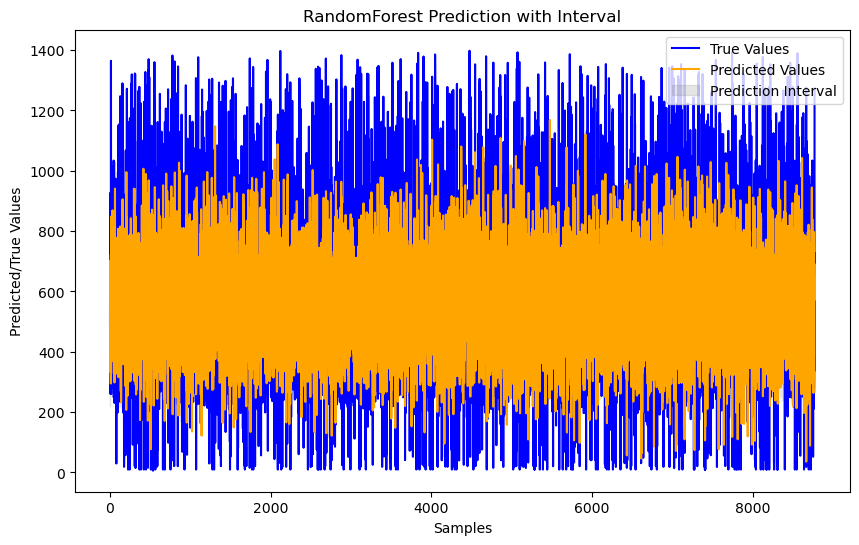

Training XGBoost...


2025/01/29 23:58:42 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpf97cc9ka/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/01/29 23:58:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost Performance:
  MAE: 191.3748
  MSE: 59649.7805
  RMSE: 244.2330
  R2: 0.2241
  MAPE: 1.1244
  Prediction Interval: 528.8444 - 925.1249


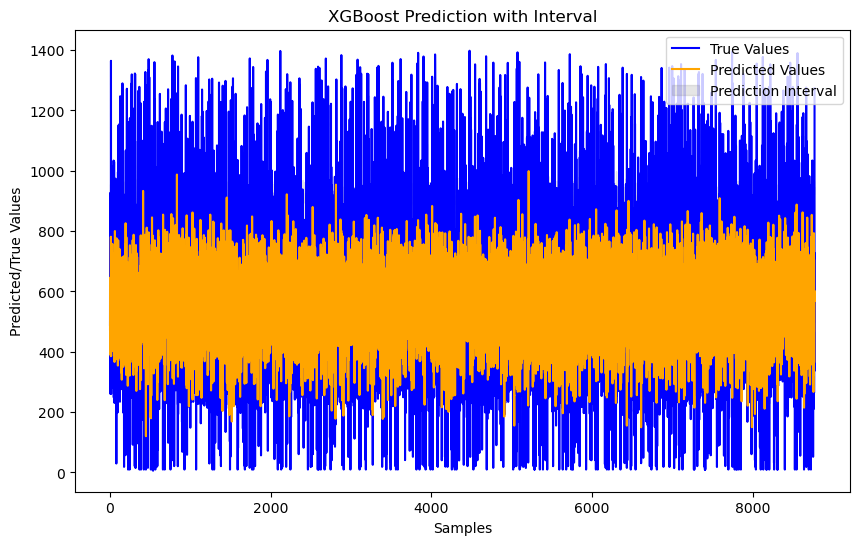

✅ Base models evaluation completed.
🏆 Selecting top models...
✅ Selected 2 best models for hyperparameter tuning.
🎯 Hyperparameter tuning in progress...
Tuning hyperparameters for XGBoost...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux201

Best Parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 100}
Performance after tuning: MAE = 190.3652, MSE = 59159.2259, RMSE = 243.2267, R2 = 0.2304, MAPE = 1.1042
Tuning hyperparameters for RandomForest...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 run_training_pipeline(                                                                       │
│   2 │   BUCKET_NAME=BUCKET_NAME,                                                                 │
│   3 │   RAW_DATA_KEY=RAW_DATA_KEY,                                                               │
│   4 │   PROCESSED_DATA_PREFIX=PROCESSED_DATA_PREFIX,                                             │
│                                                                                                  │
│ in run_training_pipeline:35                                                                      │
│                                                                                                  │
│   32 │   │                                                                                       │
│   33 │   │   # 4. Tune hyperparameters for the best models                                       │
│   34 │   │   print("🎯 Hyperparameter tuning in progress...")                                    │
│ ❱ 35 │   │   tuned_report, best_model = tune_hyperparameters(X_train, X_test, y_train, y_test    │
│   36 │   │   print("✅ Hyperparameter tuning completed.")                                        │
│   37 │   │                                                                                       │
│   38 │   │   # 5. Save the final best model to S3                                                │
│                                                                                                  │
│ in tune_hyperparameters:22                                                                       │
│                                                                                                  │
│   19 │   │   │   │   grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,    │
│   20 │   │   │                                                                                   │
│   21 │   │   │   # Fit the model using grid search                                               │
│ ❱ 22 │   │   │   grid_search.fit(X_train, y_train)                                               │
│   23 │   │   │                                                                                   │
│   24 │   │   │   # Best model and parameters                                                     │
│   25 │   │   │   best_model_temp = grid_search.best_estimator_                                   │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1473 in       │
│ wrapper                                                                                          │
│                                                                                                  │
│   1470 │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation               │
│   1471 │   │   │   │   )                                                                         │
│   1472 │   │   │   ):                                                                            │
│ ❱ 1473 │   │   │   │   return fit_method(estimator, *args, **kwargs)                             │
│   1474 │   │                                                                                     │
│   1475 │   │   return wrapper                                                                    │
│   1476                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-pac

In [43]:
run_training_pipeline(
    BUCKET_NAME=BUCKET_NAME,  
    RAW_DATA_KEY=RAW_DATA_KEY,
    PROCESSED_DATA_PREFIX=PROCESSED_DATA_PREFIX,
    models=models,  
    param_grids=param_grids 
)